Import Modul yang diperlukan

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Membuka file data rumah
data = pd.read_excel("rumahjak.xls")

In [3]:
data

,harga,luas_tanah,luas_bangunan,kamar_tidur,kamar_mandi,lantai,lokasi
0,1900000000,118,80,3,1,1,jakarta_pusat
1,1400000000,52,102,4,2,2,jakarta_pusat
2,1500000000,91,91,10,6,3,jakarta_pusat
3,2500000000,105,150,5,4,2,jakarta_pusat
4,4000000000,160,160,4,3,1,jakarta_pusat
...,...,...,...,...,...,...,...
1133,27900000000,625,750,6,5,2,jakarta_barat
1134,6500000000,871,200,3,2,1,jakarta_barat
1135,2650000000,125,185,3,3,2,jakarta_barat
1136,3500000000,288,245,4,4,2,jakarta_barat


Exploratory Data Analysis (EDA)

In [4]:
#Menampilkan informasi data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   harga          1138 non-null   int64 
 1   luas_tanah     1138 non-null   int64 
 2   luas_bangunan  1138 non-null   int64 
 3   kamar_tidur    1138 non-null   int64 
 4   kamar_mandi    1138 non-null   int64 
 5   lantai         1138 non-null   int64 
 6   lokasi         1138 non-null   object
dtypes: int64(6), object(1)
memory usage: 62.4+ KB


In [5]:
data.describe()

,harga,luas_tanah,luas_bangunan,kamar_tidur,kamar_mandi,lantai
count,1.138000e+03,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000
mean,4.190956e+09,181.119508,196.557118,3.876977,3.059754,2.007909
std,6.573193e+09,325.735204,177.297034,1.658850,1.435183,0.658433
min,1.250000e+08,27.000000,29.000000,1.000000,1.000000,1.000000
25%,1.200000e+09,67.000000,84.000000,3.000000,2.000000,2.000000
50%,2.400000e+09,107.500000,148.000000,4.000000,3.000000,2.000000
75%,4.500000e+09,200.000000,250.000000,5.000000,4.000000,2.000000
max,8.500000e+10,8200.000000,1680.000000,12.000000,10.000000,6.000000


In [6]:
from scipy import stats

<Axes: xlabel='harga', ylabel='Count'>

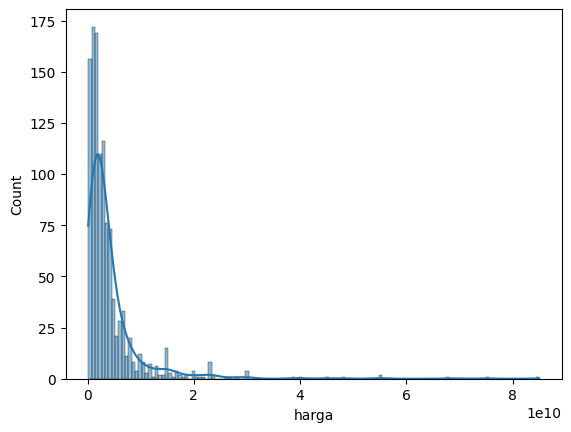

In [7]:
sns.histplot(data['harga'],kde=True)

<Axes: xlabel='harga', ylabel='Count'>

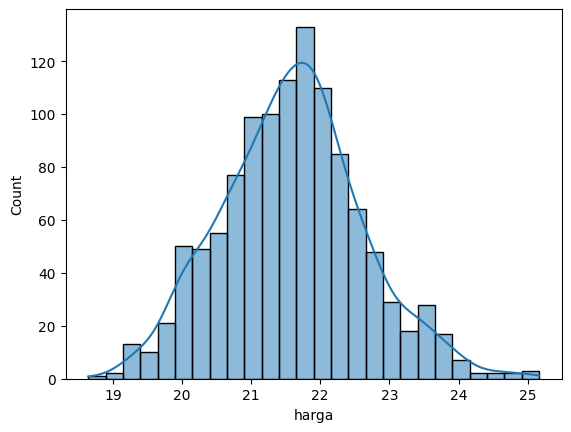

In [8]:
data['harga'] = np.log1p(data['harga'])
sns.histplot(data['harga'],kde=True)

In [9]:
# Menghitung jumlah rumah dijual di setiap lokasi
jumlah_rumah_per_lokasi = data['lokasi'].value_counts()

# Menampilkan hasil
print(jumlah_rumah_per_lokasi)

lokasi
jakarta_barat      371
jakarta_timur      249
jakarta_selatan    225
jakarta_utara      171
jakarta_pusat      122
Name: count, dtype: int64


<Figure size 1500x800 with 0 Axes>

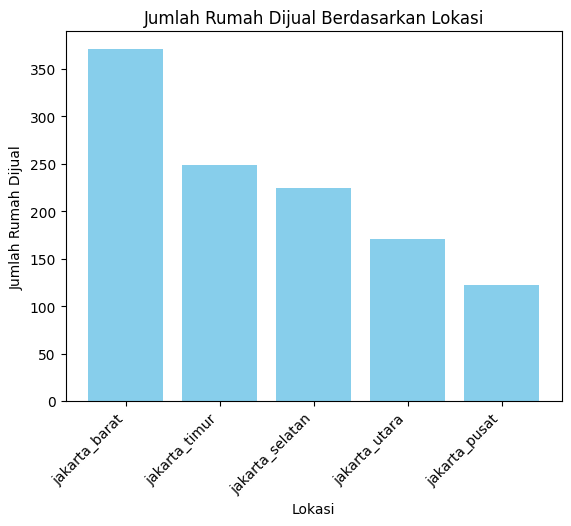

<Figure size 1500x800 with 0 Axes>

In [10]:
# Membuat histogram
plt.bar(jumlah_rumah_per_lokasi.index, jumlah_rumah_per_lokasi.values, color='skyblue')
plt.xlabel('Lokasi')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Rumah Dijual')
plt.title('Jumlah Rumah Dijual Berdasarkan Lokasi')
plt.figure(figsize=(15, 8))

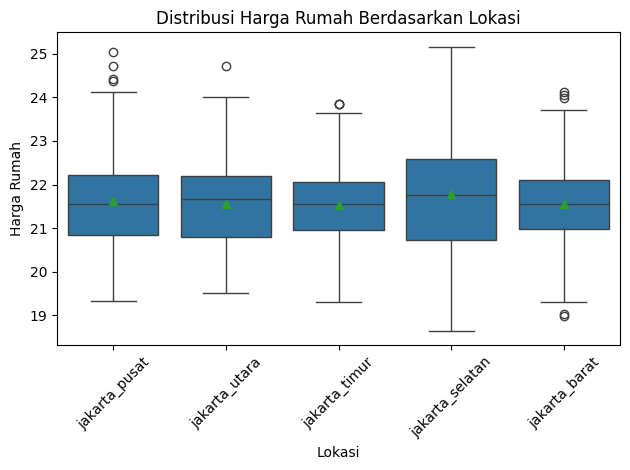

In [11]:
# Create a boxplot
sns.boxplot(
    x = "lokasi",
    y = "harga",
    showmeans=True,  # Show means as points on top of the boxes
    data=data)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title('Distribusi Harga Rumah Berdasarkan Lokasi')
plt.xlabel('Lokasi')
plt.ylabel('Harga Rumah')
plt.tight_layout()
plt.show()

In [12]:
#Distribusi Harga di setiap lokasi
harga_lokasi = data.groupby('lokasi')['harga'].describe()

In [13]:
harga_lokasi

,count,mean,std,min,25%,50%,75%,max
lokasi,,,,,,,,
jakarta_barat,371.0,21.543796,0.887508,18.980297,20.985630,21.556175,22.100765,24.124463
jakarta_pusat,122.0,21.625417,1.073906,19.336971,20.850534,21.545186,22.227343,25.040754
jakarta_selatan,225.0,21.774308,1.284265,18.643824,20.723266,21.752885,22.595068,25.165917
jakarta_timur,249.0,21.522497,0.885823,19.296149,20.946409,21.556175,22.058267,23.858760
jakarta_utara,171.0,21.553968,1.012588,19.515954,20.785933,21.659359,22.204612,24.730599


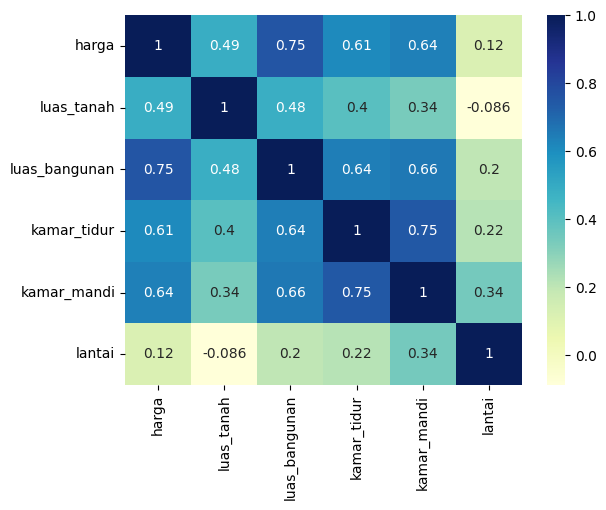

In [14]:
# Select the columns that are numerical (dtype='int64' or 'float64')
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Calculate the correlation matrix for the numerical columns
corr_matrix = data[numerical_cols].corr()

# Create the heatmap with annotations, colormap, and figure size
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

In [15]:
corr_matrix["harga"].sort_values(ascending=False)

harga            1.000000
luas_bangunan    0.754200
kamar_mandi      0.636095
kamar_tidur      0.613248
luas_tanah       0.487960
lantai           0.119020
Name: harga, dtype: float64

<Axes: xlabel='lantai', ylabel='harga'>

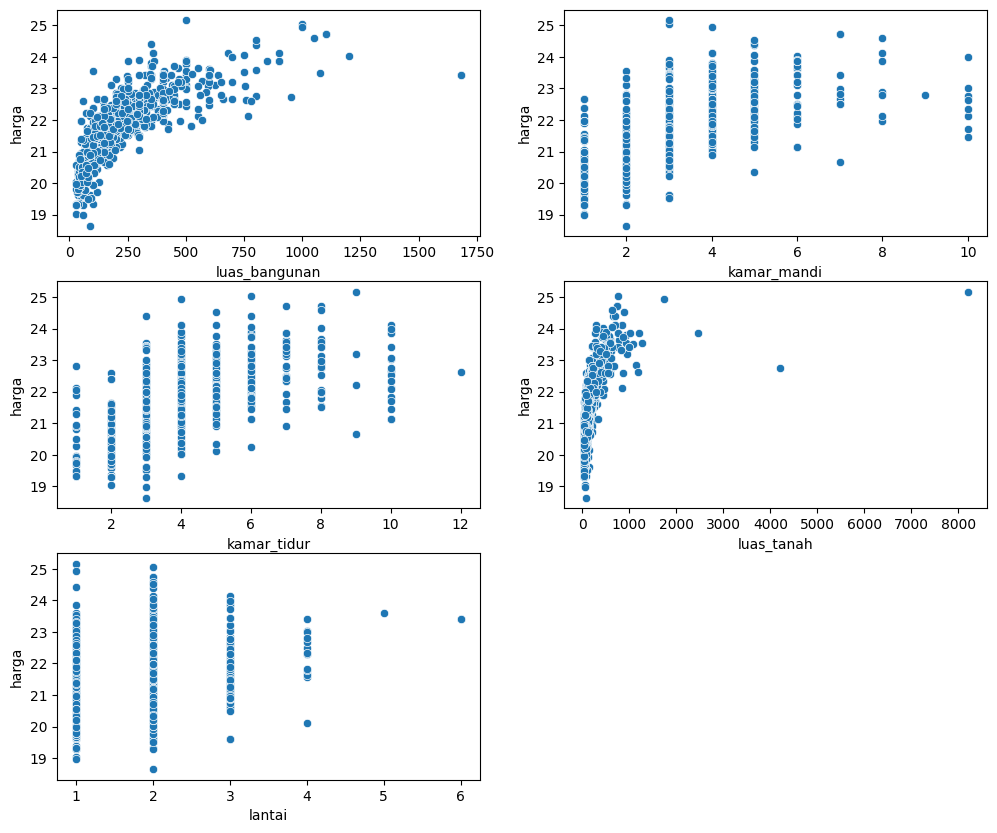

In [16]:
fig = plt.figure(figsize=(12,10))
#lb
plt.subplot(321)
sns.scatterplot(data=data, x='luas_bangunan', y="harga")
#km
plt.subplot(322)
sns.scatterplot(data=data, x='kamar_mandi', y="harga")
#kt
plt.subplot(323)
sns.scatterplot(data=data, x='kamar_tidur', y="harga")
#lt
plt.subplot(324)
sns.scatterplot(data=data, x='luas_tanah', y="harga")
#lantai
plt.subplot(325)
sns.scatterplot(data=data, x='lantai', y="harga")

In [17]:
import scipy.stats as stats
from scipy.stats import skew

In [18]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(high_skew)

luas_tanah       15.527357
luas_bangunan     2.838744
kamar_mandi       1.359654
kamar_tidur       1.352545
lantai            0.731477
dtype: float64


In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [20]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

In [21]:
num_cols = num_cols.drop('harga')

In [22]:
cat_cols = ['lokasi']

In [23]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [24]:
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [25]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', cat_pipeline, cat_cols),],
    remainder='passthrough', 
    n_jobs=-1)

In [26]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [27]:
X = data.drop('harga', axis=1)
y = data['harga']

In [29]:
import statsmodels.api as sm

In [32]:
X_preprocessed = pipeline.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2)

Linear Regression

In [34]:
lr = LinearRegression()

In [35]:
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
y_pred_test_lr = lr.predict(X_test)

In [37]:
# R-squared
r2 = r2_score(y_test, y_pred_test_lr)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_test_lr)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_test_lr)
# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_test_lr) * 100  # Convert to percentage

print("R-squared:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)

R-squared: 0.6176678838985279
MAE: 0.46624719074258686
MSE: 0.4119451279157101
MAPE: 2.162510804829929


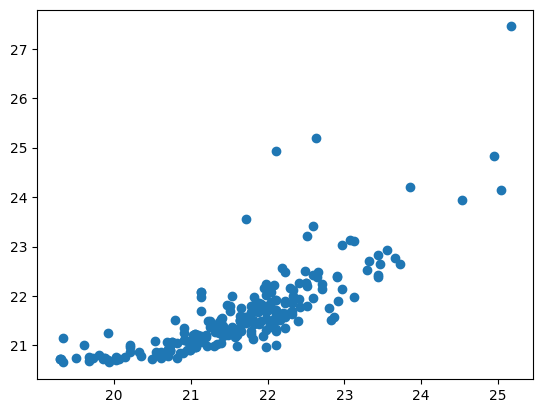

In [38]:
plt.scatter(y_test, y_pred_test_lr);

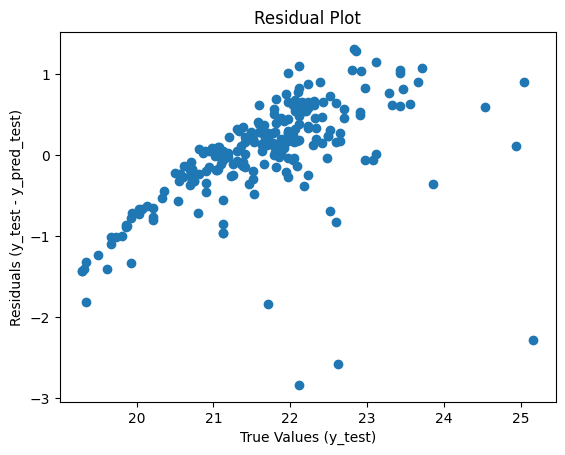

In [39]:
# Calculate residuals (difference between actual and predicted)
residuals = y_test - y_pred_test_lr

# Create a scatter plot of residuals vs y_test
plt.scatter(y_test, residuals)

# Add labels and title
plt.xlabel("True Values (y_test)")
plt.ylabel("Residuals (y_test - y_pred_test)")
plt.title("Residual Plot")

plt.show()

Random Forest Regression

In [40]:
rfr = RandomForestRegressor(random_state=13)

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Default parameter pada RandomForestRegressor
n_estimators = 100  # Number of decision trees
max_depth = None  # Maximum depth of each tree
min_samples_split = 2  # Minimum number of samples required to split a node
min_samples_leaf = 1  # Minimum number of samples required at each leaf node

# Create the model
rfr = RandomForestRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           min_samples_split=min_samples_split,
                           min_samples_leaf=min_samples_leaf)

In [42]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [43]:
y_pred_test_rfr = rfr.predict(X_test)

In [44]:
# R-squared
r2 = r2_score(y_test, y_pred_test_rfr)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_test_rfr)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_test_rfr)
# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_test_rfr) * 100  # Convert to percentage

print("R-squared:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)

R-squared: 0.8203589644206121
MAE: 0.30844280603813656
MSE: 0.19355488661334738
MAPE: 1.4182566657418063


In [45]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error 
import random  # Import the random module

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [5, 10, 20, 50],  # Maximum depth of trees
    'min_samples_split': [2, 4, 8, 20],  # Minimum samples to split a node
    'min_samples_leaf': [1, 5, 10, 20] # Minimum samples leaf
}

In [46]:
rfr_cv = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
rfr_cv.fit(X_train, y_train)

In [60]:
rfr_cv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

In [68]:
rfr_cv.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=13)

In [61]:
# Make predictions on test data
y_pred_cv = rfr_cv.best_estimator_.predict(X_test)

In [62]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_cv)
mae = mean_absolute_error(y_test, y_pred_cv)
mse = mean_squared_error(y_test, y_pred_cv)
mape = mean_absolute_percentage_error(y_test, y_pred_cv)

# Print the results
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared: 0.8859237762672406
Mean Absolute Error (MAE): 0.2738342571212902
Mean Squared Error (MSE): 0.12554090813661334
Mean Absolute Percentage Error (MAPE): 0.01254475476778805


In [63]:
random_forest_oob = RandomForestRegressor(oob_score=True)
random_forest_oob.fit(X_train, y_train)
print(random_forest_oob.oob_score_)

0.8041289824331044


Feature Importance Based on MDI

In [94]:
import time

import numpy as np

start_time = time.time()
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


In [102]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

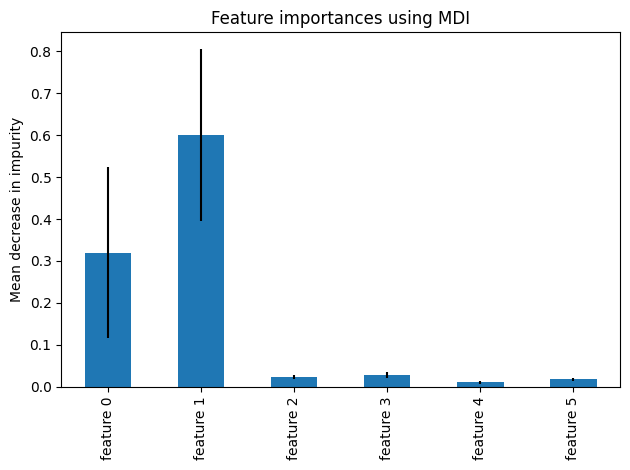

In [104]:
import pandas as pd

rfr_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rfr_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()